In [ ]:
import tensorflow as tf

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import time
import functools

In [ ]:
content_path="/content/content.jpg"
style_path="/content/style.jpg"

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)#reads the imagefrom its path.
  img = tf.image.decode_image(img, channels=3)#detects the type of image and converts it to tensor
  img = tf.image.convert_image_dtype(img, tf.float32) #converts the pixels to float

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) #takes height and width as float
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]# increases the dimension
  return img

In [ ]:
# to display an image


def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)


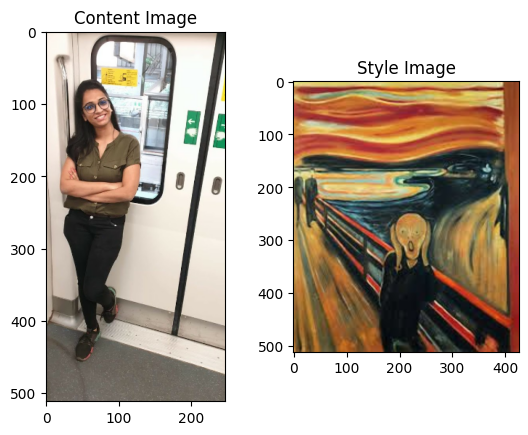

In [ ]:

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet') # taking vgg 19 model without the later output layers.

vgg.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
vgg.trainable=False

In [ ]:
vgg.input

<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
for layer in vgg.layers:
  print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv4'] 

# Style layer of interest
style_layers = ['block1_conv2',
                'block2_conv2',
                'block3_conv4', 
                'block4_conv4', 
                'block5_conv4']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
for name in style_layers:
  print(vgg.get_layer(name))

In [ ]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)


#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv2
  shape:  (1, 511, 426, 64)
  min:  0.0
  max:  2825.9219
  mean:  133.36221

block2_conv2
  shape:  (1, 255, 213, 128)
  min:  0.0
  max:  6305.9473
  mean:  126.15826

block3_conv4
  shape:  (1, 127, 106, 256)
  min:  0.0
  max:  11481.817
  mean:  513.0769

block4_conv4
  shape:  (1, 63, 53, 512)
  min:  0.0
  max:  5197.033
  mean:  39.42776

block5_conv4
  shape:  (1, 31, 26, 512)
  min:  0.0
  max:  143.50006
  mean:  1.0119549



In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #forms the gram matrix.
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
style_layers+content_layers

['block1_conv2',
 'block2_conv2',
 'block3_conv4',
 'block4_conv4',
 'block5_conv4',
 'block5_conv4']

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs) # ENCODES A BATCH OF IMAGES TO THE VGG19 MODEL
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}



#When called on an image,
# this model returns the gram matrix (style) of the style_layers and content of the content_layers

In [ ]:
l=[1,2,3]
l1=['a','b','c']
for i,j in zip(l,l1):
  print(i,j)

1 a
2 b
3 c


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)


In [ ]:
style_targets = extractor(style_image)['style']

In [ ]:
content_targets = extractor(content_image)['content']

In [ ]:
image = tf.Variable(content_image)# IMAGE GENERATED

In [ ]:
#np.random.randn(content_image.shape)

In [ ]:
"""def norm(image):
  image=image.numpy()
  return (image/255).astensor()"""

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

image.assign(clip_0_1(image))
# SINCE THE MODEL ACCEPTS VALUES IN BETWEEN 0 AND 1 SO WE CLIP IT.

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#To optimize this, use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4

In [ ]:
d= {'name':'sweta', 'surname': 'shaw'}
d.keys()

dict_keys(['name', 'surname'])

In [ ]:
d['name']

'sweta'

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) #reduce_mean Computes the mean of elements across dimensions of a tensor.
                           for name in style_outputs.keys()]) #add_n Adds all input tensors element-wise.
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

In [ ]:
total_variation_weight=1e-4

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*total_variation_loss(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  #image is updated image
  image.assign(clip_0_1(image))




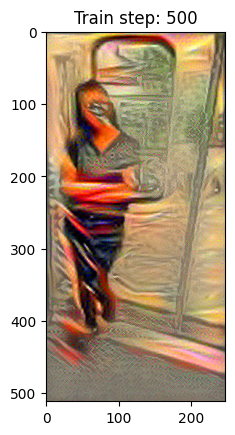

Total time: 2651.2


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0 #counter
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  imshow(image.read_value())
  plt.title("Train step: {}".format(step))
  plt.show()

end = time.time()
print("Total time: {:.1f}".format(end-start))